Interactive version of the tutorial: [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/pgrigorev/neighbors-maps.git/HEAD?labpath=tutorials%2Fdefect_detection.ipynb)

In [1]:
import matplotlib.pyplot as plt
from bokeh.io import output_notebook
output_notebook()


import sys
sys.path.insert(0, "../")
from neighbor_map import Atoms
from ase.atoms import Atom


def get_cutoff(atoms, n_neightbours, cutoff=10.):
    """
    Function to get the distance of n_th neighbour using matscipy neighbour list.
    """
    from matscipy.neighbours import neighbour_list

    i, d = neighbour_list("id", atoms, cutoff=cutoff)
    first_atom_d = d[i == 0]
    first_atom_d.sort()
    return first_atom_d[n_neightbours]

from helper_functions import interactive_neighbour_map

Loading BokehJS ...

# Construction of a lightweight descriptor of atomic environment

In this tutorial we will implement a [recently proposed](https://arxiv.org/abs/2307.00978) of atomic enviroment called _neighbour maps_.

To understand better how neighbour maps are constructed we will look at four examples of cubic structures:
- Simple Cubic (SC): Po 
- Bulk Centered Cubic (BCC): Fe
- Face Centered Cubic (FCC): Ni
- Diamond: C

[Atomic Simulations Environment (ASE)](https://wiki.fysik.dtu.dk/ase/) has an excellent set of tools for [building things](https://wiki.fysik.dtu.dk/ase/ase/build/build.html). We just need to provide the symbol of the element and it will create a unit cell with the structure and lattice parameter from the internal database. 

In [2]:
from ase.build import bulk

unit_cells = []
for symbol in ["Po", "Fe", "Ni", "C"]:
    unit_cells.append(bulk(symbol, cubic=True))
    

Lets have a look on the structures. We will use a tool called [nglview](https://github.com/nglviewer/nglview) for interactive visulisations. A very detailed explanation of the interface can be found in [this tutorial](https://projects.volkamerlab.org/teachopencadd/talktorials/T017_advanced_nglview_usage.html#Practical) and also one can look at the [documentation]().

An alternative wa to visualise atomistic structures is to us use [Open Visualisation Tool Ovito](https://www.ovito.org/) which has a user freindly interface and provides a wide range of analysis algorythms. To do this one has to save the structure using built in `write()` function and open it Ovito:
```python
for label, structure in zip(labels, structures):
    structure.write(label + '.xyz')
```

In [10]:
def show_structures(structures, labels):
    from nglview import show_ase, ASEStructure

    # create an empty canvas
    view = show_ase(structures[0], default_representation=False)
    view.remove_component(view[0])

    for label, structure in zip(labels, structures):
        # add new component to visualise
        component  = view.add_component(ASEStructure(structure), default_representation=False, name=label + " " + str(structure.symbols))
        
        # set up the vew as just atomic spheres with unit cell
        scale=0.5
        component.add_spacefill()
        component.update_spacefill(radiusType='covalent',
                                radiusScale=scale)
        component.add_unitcell()

        # show only simple cubic in starting window
        if label != "Simple Cubic":
            component.hide()

    view.camera = 'orthographic'
    view.parameters = {"clipDist": 0}

    view.gui_style = "NGL"
    return view


In [11]:
labels = ["Simple Cubic", "BCC", "FCC", "Diamond"]
show_structures(unit_cells, labels=labels)


NGLWidget(gui_style='ngl')

Lets look on the larger cells that we will use as a mode of bulk structures. To create on we just need to replicate the unit cell N times in each directions. We will use the cells of size 4x4x4 in this tutorial.

In [14]:
bulks = []

for unit_cell in unit_cells:
    bulk = unit_cell * [4, 4, 4]
    bulks.append(Atoms(bulk))

The idea behind neighbour maps is to find a simple mapping of an atomic environment into an image that can be used for training a convolutional neural network. From the lecture you might remember that this operation should be invariant with respect to rigid translations, rotations and permutations. One of such operation is a simply taking a distances of a number of neighbours N around an atom and sorting them. This is then repeated for each neihbour giving a mateix of size NxN. Since the closer neighbours are more important final mapping to the image is proportinal to the inverse of the distance 1/D. Taking an example of a BCC structure (Fe) we will now see how this operation can be used to describe an atomic environment around a certain atom and check if it satisfies the desired criteria to be a descriptor.


In [20]:
show_structures(bulks, labels=labels)

NGLWidget(gui_style='ngl')

In [19]:
Fe = bulks[1]

interactive_neighbour_map(Fe, target_img_size=8, cutoff_factor=1.0)

To further understand the building process of neighbour maps you can use `show_strucrues()` and `interative_neighbour_maps()` functions to explore Simple Cubic, Face Centered and Diamond structures as well as parameters of builfing the maps: `target_image_size` and `cutoff_factor`.

# Neighbour maps for defects

Now we will look how neighbour maps description of the atomic environment changes when a defect is present. We will look at two cases of a missing atom - vacancy and an extra atom - interstitial.

In [21]:
vacancies = []
interstitials = []

for bulk in bulks:

    vacancy = bulk.copy()
    # delete atom with index 1
    del vacancy[1]
    vacancies.append(Atoms(vacancy))

    # add an atom
    interstitial = bulk.copy()
    interstitial.extend(Atom(symbol, (2.5, 2.5, 1.5)))
    interstitials.append(Atoms(interstitial))

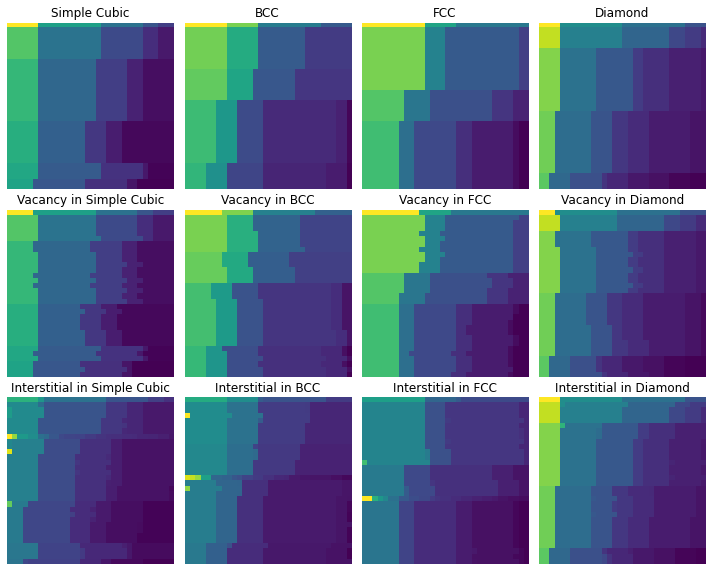

In [17]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10, 8))

for structure, title, ax in zip(bulks, labels, axes[0]):

    ax.imshow(structure.get_descriptor(atom_id=0, r_cut=1.2 * get_cutoff(structure, 32), img_target_size=32))
    ax.set_title(title)
    ax.axis("off")

for structure, title, ax in zip(vacancies, labels, axes[1]):

    ax.imshow(structure.get_descriptor(atom_id=0, r_cut=1.2 * get_cutoff(structure, 32), img_target_size=32))
    ax.set_title("Vacancy in " + title)
    ax.axis("off")


for structure, title, ax in zip(interstitials, labels, axes[2]):

    ax.imshow(structure.get_descriptor(atom_id=0, r_cut=1.2 * get_cutoff(structure, 32), img_target_size=32))
    ax.set_title("Interstitial in " + title)
    ax.axis("off")

    
fig.tight_layout()

It can be seen that the neighbours map reflects very well the change of a local atomic environment due to a presence of a defect. At the same time it keeps the features of the host lattice, i. e. we still can recognise the crystallographic structure by looking at the image. This naturally leads to two main applications of neighbour maps: structure recognition and defect identification. However so far we looked to these maps with our naked eyes (and brains), which are in fact a very good tool to look examine an image. Can we train a neural network to perform a similar analysis and recognition?

It is suggested to use `show_strucrues()` and `interative_neighbour_maps()` functions to look at `vacancies` and `interstitials`to understand why the resulting neighbour maps look like this.